<a href="https://colab.research.google.com/github/zxzhaixiang/MachineLearning_demo/blob/master/boosting_tree_quantile_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

import lightgbm

from functools import partial

np.random.seed(1)

In [0]:
## sample function
def get_y(x, err = 1, fun='sinc'):
    e = np.random.randn(*x.shape)*err
    y = x*np.sin(x)
    return y+e

def get_data(n = 1000, err = 0.1, split=0.2):
    x = np.linspace(0,10,n)
    y = get_y(x, err = err)
    y_exact = get_y(x, err = 0)

    ind = np.arange(n)
    np.random.shuffle(ind)
    ind_split = int(n*(1-split))
    ind_train = np.sort(ind[:ind_split])
    ind_test = np.sort(ind[ind_split:])

    return x[ind_train].reshape(-1,1), y[ind_train], x[ind_test].reshape(-1,1), y[ind_test], x, y_exact

In [0]:
def plot_results(x,y_exact,xtrain, ytrain, xtest, ytest, y_pred, y_upper = None, y_lower = None):
    plt.plot(x,y_exact,'b--',label='exact')
    plt.plot(xtrain, ytrain, '.', markersize=10, label=u'train')
    plt.plot(xtest, ytest, 'o', markersize=10, label=u'test')
    plt.plot(xtest, y_pred, 'r-', label=u'Prediction')
    if y_upper is not None and y_lower is not None:
        plt.plot(xtest, y_upper, 'k-')
        plt.plot(xtest, y_lower, 'k-')
        plt.fill(np.concatenate([xtest, xtest[::-1]]),
                np.concatenate([y_upper, y_lower[::-1]]),
                alpha=.1, fc='b', ec='None', label='90% prediction interval')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(-10, 20)
    plt.legend(loc='upper left')

In [0]:
def soft_quantile_loss_wrapper(alpha = 0.5, delta = 0.25):
    '''
    use asymmetric huber loss
    d1 = delta*(1-alpha)
    d2 = delta*alpha

    L = 0.5*e^2        if   -d1<e<d2
        d1*(|e|-d1/2)  if e<-d1
        d2*(|e|-d2/2)  if         d2<e

    g = e              if   -d1<e<d2
        -d1            if e<-d1
        d2             if         d2<e

    H = 1              if   -d1<e<d2
        0              if e<-d1
        0              if         d2<e
    '''
    d1 = delta*(1-alpha)
    d2 = delta*alpha

    def soft_quantile_loss(y_true, y_pred):
        r = (y_true - y_pred).astype("float")
        grad = np.where(-r<-d1, -d1, -r)
        grad = np.where(-r<d2, grad, d2)
        
        hess = np.where((-r>-d1) & (-r<d2), 1, 0)

        return grad, hess
    
    return soft_quantile_loss

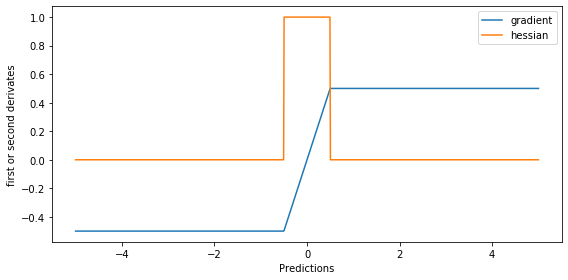

In [5]:
y_pred = np.linspace(-5,5,1000)
y_true = np.repeat(0,1000)
grad, hess = soft_quantile_loss_wrapper(alpha=0.5,delta=1)(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,4))

# ax.plot(y_hat, errors)
ax.plot(y_pred, grad)
ax.plot(y_pred, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Predictions')
ax.set_ylabel('first or second derivates')

fig.tight_layout()

## Fit

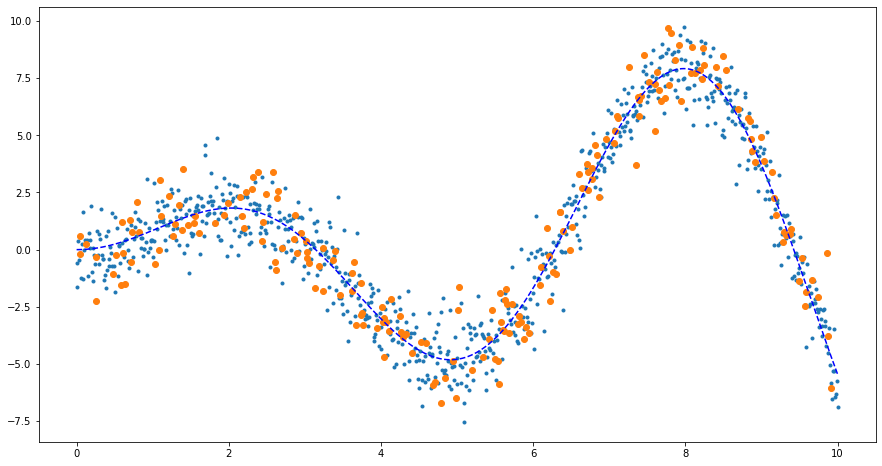

In [137]:
n = 1000
err = 1

xtrain, ytrain, xtest, ytest, x, y_exact = get_data(n = n, err = err, split = 0.2)
plt.figure(figsize=(15,8))
plt.plot(xtrain,ytrain,'.')
plt.plot(xtest,ytest,'o')
plt.plot(x,y_exact,'b--')


In [0]:
alpha=0.95
delta = 0.2

In [0]:
res = {}

In [140]:
xg_param = {'n_estimator': 100, 'max_depth':6, 'learning_rate': 0.2, 'tree_method':'exact'}
xg_param = {}

regressor = XGBRegressor(objective = soft_quantile_loss_wrapper(0.5, delta), **xg_param)
y_pred = regressor.fit(xtrain,ytrain).predict(xtest)

regressor = XGBRegressor(objective = soft_quantile_loss_wrapper(alpha, delta), **xg_param)
y_lower = regressor.fit(xtrain,ytrain).predict(xtest)

regressor = XGBRegressor(objective = soft_quantile_loss_wrapper(1-alpha, delta), **xg_param)
y_upper = regressor.fit(xtrain,ytrain).predict(xtest)

res['xg'] = {'pred':y_pred, 'upper':y_upper, 'lower': y_lower, 'title': 'xgboost - asymmetric huber'}

[04:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
gb_param = {'n_estimators':100, 'max_depth':8, 'learning_rate':.1, 'min_samples_leaf':9,'min_samples_split':9}
clf = GradientBoostingRegressor(loss='quantile', alpha=alpha)

y_lower = clf.fit(xtrain, ytrain).predict(xtest)

clf.set_params(alpha=1.0 - alpha)
y_upper = clf.fit(xtrain, ytrain).predict(xtest)

clf.set_params(loss='ls')
y_predict = clf.fit(xtrain, ytrain).predict(xtest)

res['gb'] = {'pred':y_pred, 'upper':y_upper, 'lower': y_lower, 'title': 'gb tree - built-in quantile'}

In [0]:
#lgbm_param = {'num_leaves':100, 'max_depth': 10, 'n_estimators': 250}
lgbm_param = {}
#lgbm_param = {'num_leaves': 200, 'max_depth':6, 'learning_rate': 0.2, 'gamma': 0.5, 'tree_method':'exact'}


gbm = lightgbm.LGBMRegressor(objective=soft_quantile_loss_wrapper(0.5, delta), **lgbm_param)
gbm.fit(xtrain, ytrain) 
y_pred = gbm.predict(xtest)
gbm = lightgbm.LGBMRegressor(objective=soft_quantile_loss_wrapper(alpha), **lgbm_param)
gbm.fit(xtrain, ytrain) 
y_lower = gbm.predict(xtest)
gbm = lightgbm.LGBMRegressor(objective=soft_quantile_loss_wrapper(1-alpha, delta), **lgbm_param)
gbm.fit(xtrain, ytrain) 
y_upper = gbm.predict(xtest)

res['lightgbm_1'] = {'pred':y_pred, 'upper':y_upper, 'lower': y_lower, 'title': 'lightgbm - asymmetric huber'}


In [0]:
gbm = lightgbm.LGBMRegressor(objective='quantile', alpha = 0.5, **lgbm_param)
y_pred = gbm.fit(xtrain, ytrain).predict(xtest)

gbm = lightgbm.LGBMRegressor(objective='quantile', alpha = alpha, **lgbm_param)
y_lower = gbm.fit(xtrain, ytrain).predict(xtest)

gbm = lightgbm.LGBMRegressor(objective='quantile', alpha = 1-alpha,  **lgbm_param)
y_upper = gbm.fit(xtrain, ytrain).predict(xtest)

res['lightgbm_2'] = {'pred':y_pred, 'upper':y_upper, 'lower': y_lower, 'title': 'lightgbm - built-in quantile loss'}


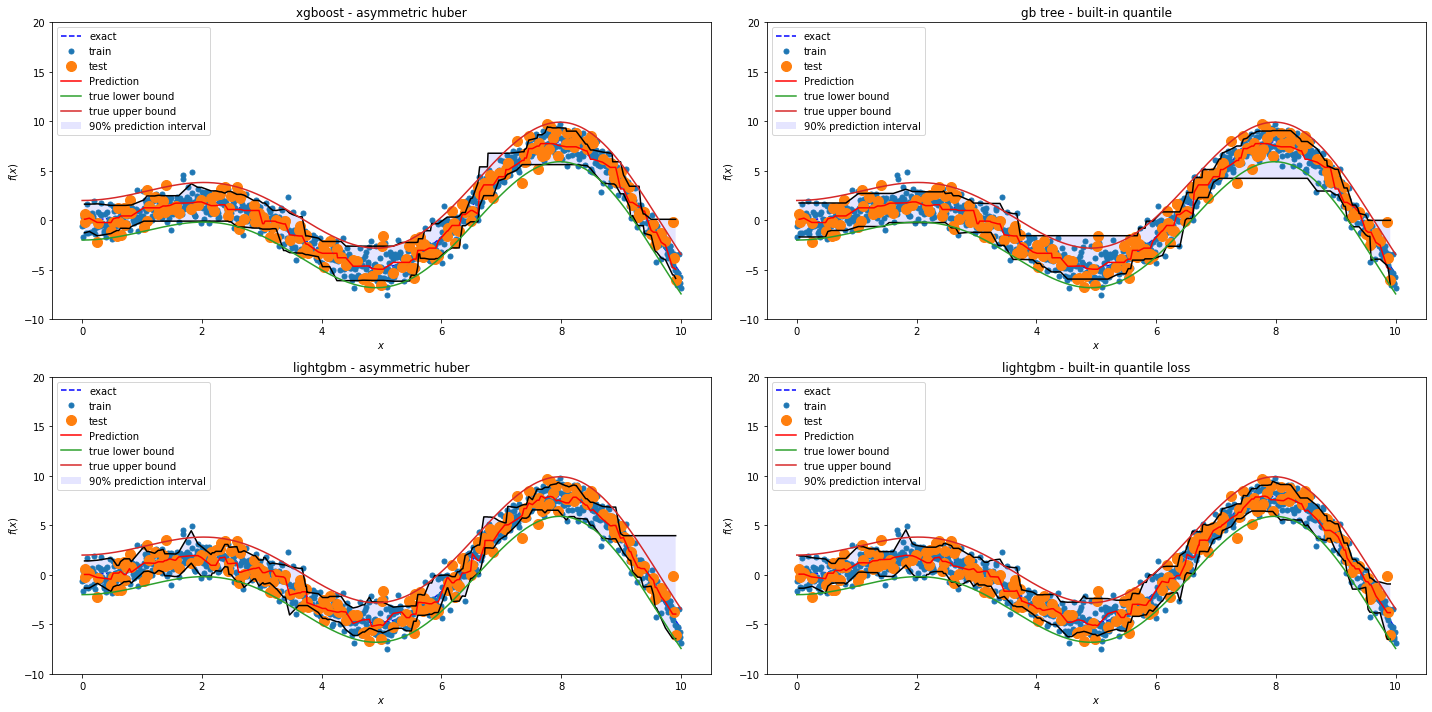

In [150]:
plt.figure(figsize=(20,10))
for i, key in enumerate(res):
    plt.subplot(2,len(res)//2,i+1)
    y_pred, y_upper, y_lower, title = res[key]['pred'], res[key]['upper'], res[key]['lower'], res[key]['title'] 
    plot_results(x, y_exact, xtrain, ytrain, xtest, ytest, y_pred, y_upper, y_lower)
    plt.plot(x,y_exact-err*2, label = 'true lower bound')
    plt.plot(x,y_exact+err*2, label = 'true upper bound')
    plt.legend()
    plt.title(title)
plt.tight_layout()